# Working with anisotropic materials

In [1]:
import numpy as np
import PyMoosh as PM
import PyMoosh.anisotropic as ani
from numpy import linalg as la_np


/home/denis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Defining variables

As usual, we will need a few general variables to define the situation: incident wavelength and angle.

We do not need the polarisation because **the anisotropic functions take into account both polarisations** and all possible couplins (p -> p, p -> s, s -> p, s -> s)

In [2]:
wl_nm = 640
theta_in_rad = np.pi/4 # Incidence angle

## Anisotropic materials
An anisotropic material is either defined by a list of optical indices (the different axes) or by a link to the RefractiveIndex Database (see `How_materials_work`).

Its relative orientation in the structure is now defined by a rotation angle (in rad) around a given rotation axis.
By default,
- `z` is the propagation axis (normal to the interfaces)
- `x` is the axis so that (xOz) is the plane of incidence
- `y` is the invariance axis

One can use these axes as strings, or define an axis in the [x, y, z] coordinates

In [3]:
perm_1 = 1.2
perm_2 = 2.2

opt_ind = [perm_1, perm_2, perm_2] # uniaxial material, 2 permittivities only
mat_1=ani.AniMaterial(opt_ind, specialType="ANI")

rot_axis1 = 'x'
rot_angle1 = 0.5
rot_axis2 = [0, 1, 1]
rot_angle2 = -0.2

## Structure

All structures must have an isotropic superstrate and substrate, here we use air as both superstrate and substrate.

Then the structure definition works like a usual PyMoosh structure, providing a list of material, the order in which they are stacked, and their respective thicknesses.

In addition to this, the rotation angles and axes must be provided, with dummy values used for isotropic layers.

All this is fed to the `AniStructure` class.

In [4]:

mat_2=PM.Material(1.0) # regular, Isotropic material (vacuum / air)

# Lists!
material_list = [mat_1, mat_2] # The materials
stack = [1, 0, 0, 1] # Which material when (as in the usual Structure function)
thickness = [0, 100, 25, 0] # The thickness of each layer (as in the usual Structure function)
ani_rot_angle = [0., rot_angle1, rot_angle2, 0.] # The rotation angle for each layer. MUST be provided for isotropic layers too, will simply be overlooked
ani_rot_axis = ['z', rot_axis1, rot_axis2, 'z']  # The rotation axis for each layer. MUST be provided for isotropic layers too, will simply be overlooked


structure1 = ani.AniStructure(material_list, stack, thickness, ani_rot_angle, ani_rot_axis, verbose=False)


Computations are easy!

Here we compute for a list of incidence angles (at a given wavelength) and retrieve all reflection and transmission coefficients of the stack.

`coefficients_ani` returns: `tpp`,`tps`,`tsp`,`tss`,`rpp`,`rps`,`rsp`,`rss`, in this order

As a reminder, **p polarisation is TM** and **s polarisation is TE**

In [5]:

thetas = np.linspace(0,80,80)*np.pi/180
l_rpp = []
l_rps = []
l_rsp = []
l_rss = []
l_tpp = []
l_tps = []
l_tsp = []
l_tss = []


for theta_in_rad in thetas:
    res = ani.coefficients_ani(structure1, wl_nm, theta_in_rad)
    l_tpp.append(res[0])
    l_tps.append(res[1])
    l_tsp.append(res[2])
    l_tss.append(res[3])
    l_rpp.append(res[4])
    l_rps.append(res[5])
    l_rsp.append(res[6])
    l_rss.append(res[7])


Plotting results as usual

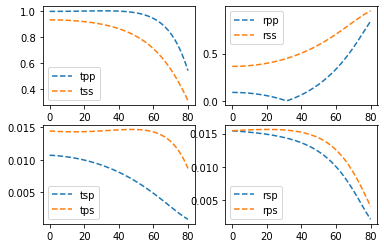

In [6]:

import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.plot(thetas*180/np.pi, np.abs(l_tpp), label='tpp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_tss), label='tss', linestyle='--')
plt.legend()

plt.subplot(2,2,2)
plt.plot(thetas*180/np.pi, np.abs(l_rpp), label='rpp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_rss), label='rss', linestyle='--')
plt.legend()

plt.subplot(2,2,3)
plt.plot(thetas*180/np.pi, np.abs(l_tsp), label='tsp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_tps), label='tps', linestyle='--')
plt.legend()

plt.subplot(2,2,4)
plt.plot(thetas*180/np.pi, np.abs(l_rsp), label='rsp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_rps), label='rps', linestyle='--')
plt.legend()
plt.show()


# Dispersive anisotropic structures

Now you can even define dispersive anisotropic structures!

In this case, each optical index works like the `Model` type of material, i.e. you have to give a list of lists, each containing:
- a function
- the potential parameters of this function (in addition to the wavelength), if any

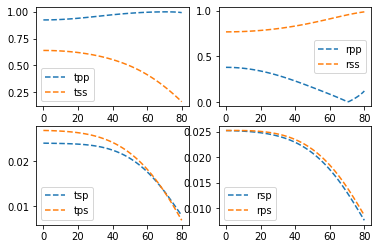

In [7]:

def Lorentz(wav, f, omega, gamma, eps):
    """
        Lorentz model, with lorentzian resonances (elastically bound electrons)
        eps is eps_inf, the background permittivity
        f, gamma, omega, sigma are the chi_b parameters (Lorentz resonances)
        f, gamma, omega, sigma must be lists (np arrays) of the same lengths
        They are given in eV (wav in nm)
    """
    w = 2*np.pi*299792458*1e9 / wav
    chi = np.sum(f/(omega**2 - w**2 - 1.0j*gamma*w))
    return eps + chi

perm_1 = [Lorentz, 1, 9, 0.5, 8]
perm_2 = [Lorentz, 1, 10, 0.5, 11]

opt_ind = [perm_1, perm_2, perm_2] # uniaxial material, 2 permittivities only
mat_1=ani.AniMaterial(opt_ind, specialType="Model_ANI")

rot_axis1 = 'x'
rot_angle1 = 0.5
rot_axis2 = [0, 1, 1]
rot_angle2 = -0.2

mat_2=PM.Material(1.0) # regular, Isotropic material (vacuum / air)

# Lists!
material_list = [mat_1, mat_2] # The materials
stack = [1, 0, 0, 1] # Which material when (as in the usual Structure function)
thickness = [0, 100, 25, 0] # The thickness of each layer (as in the usual Structure function)
ani_rot_angle = [0., rot_angle1, rot_angle2, 0.] # The rotation angle for each layer. MUST be provided for isotropic layers too, will simply be overlooked
ani_rot_axis = ['z', rot_axis1, rot_axis2, 'z']  # The rotation axis for each layer. MUST be provided for isotropic layers too, will simply be overlooked


structure1 = ani.AniStructure(material_list, stack, thickness, ani_rot_angle, ani_rot_axis, verbose=False)

thetas = np.linspace(0,80,80)*np.pi/180
l_rpp = []
l_rps = []
l_rsp = []
l_rss = []
l_tpp = []
l_tps = []
l_tsp = []
l_tss = []


for theta_in_rad in thetas:
    res = ani.coefficients_ani(structure1, wl_nm, theta_in_rad)
    l_tpp.append(res[0])
    l_tps.append(res[1])
    l_tsp.append(res[2])
    l_tss.append(res[3])
    l_rpp.append(res[4])
    l_rps.append(res[5])
    l_rsp.append(res[6])
    l_rss.append(res[7])


plt.subplot(2,2,1)
plt.plot(thetas*180/np.pi, np.abs(l_tpp), label='tpp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_tss), label='tss', linestyle='--')
plt.legend()

plt.subplot(2,2,2)
plt.plot(thetas*180/np.pi, np.abs(l_rpp), label='rpp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_rss), label='rss', linestyle='--')
plt.legend()

plt.subplot(2,2,3)
plt.plot(thetas*180/np.pi, np.abs(l_tsp), label='tsp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_tps), label='tps', linestyle='--')
plt.legend()

plt.subplot(2,2,4)
plt.plot(thetas*180/np.pi, np.abs(l_rsp), label='rsp', linestyle='--')
plt.plot(thetas*180/np.pi, np.abs(l_rps), label='rps', linestyle='--')
plt.legend()
plt.show()
